In [2]:
FOLDERNAME = "/content/drive/MyDrive/Colab Notebooks/CS229 Final/"
%cd $FOLDERNAME

import numpy as np
import pandas as pd
from google.colab import data_table
data_table.enable_dataframe_formatter
from matplotlib import pyplot as plt
from collections import defaultdict
from sklearn.neighbors import KNeighborsClassifier


/content/drive/MyDrive/Colab Notebooks/CS229 Final
 Confusion_matrix_DT.png           KNN_test_data.npy
 Confusion_matrix_kNN.png          KNN_train_data.npy
 Confusion_matrix_logreg.png       KNN_unnormalized_only_ordinal.npy
 Confusion_matrix_nn.png           logregvsknnconfusion.png
 Confusion_matrix_RF.png           model1.sav
 Data/                             model2_earlystop.sav
 figure1.png                       model3_earlystop.sav
'Final project.ipynb'              model4_earlystop.sav
 kmeans_normalzied.png             processed_data.npy
 kmeans_unnormalzied.png           train_and_test_acc_dectree.png
 KNN_normalized_full_pca.npy       train_and_test_acc_dectree_zoom.png
 KNN_normalized_full_pca.png       train_and_test_acc_randforest.png
 KNN_normalized_only_ordinal.npy   train_and_test_acc_randforest_wider.png


In [5]:
full_dataset = pd.read_csv("./Data/Diabetes_Data_1999_2008.csv")
FULL_DATASET_SIZE = full_dataset.size
# full_dataset
# print(full_dataset)
def get_possible_values(dataset_arg, verbose=True):
  possible_values = {}
  for column_name, column_data in dataset_arg.iteritems():
    possible_values[column_name] = set(column_data)
    # print(column_name)
  if (verbose):
    print(dataset_arg.columns)
    for key in possible_values:
      if(key == 'encounter_id' or key == 'patient_nbr'): continue
      print(str(key) + ": " + str(possible_values[key]))
  return possible_values
possible_values = get_possible_values(full_dataset, False)

A quick inspection of the shows that most of these columns cannot be represented with simple binary features, in fact even readmission cannot be represented as binary because we must differentiated betwen no readmission, readmission after 30 days, and readmission within 30 days. However, there is no way to transform these into a label encoding without imposing unnecessary relations on the features. For instance, for the outputs, we could naively assign 'NO' to 0, '< 30' to 1, and '> 30' to 2. However, this implies spurious facts like the average of 'NO' and '> 30' is '< 30', or that '> 30' is twice '< 30'. Although in this case the hierachy of the numbers may be welcome, it is better to let our model to learning this on its own. A more obvious examples are the various diagnoses, while these have numbers assigned, they are assigned according to the ICD 9 standard, and again the actual numbers mean less than the actual identity of the diagnosis. For these it will be necessary to use a onehot encoding, despite the huge dimensionality this would involve. To reduce the dimensionality, we will run PCA. 

We also notice that some of the columns only contain one possible value, we can simply drop these columns as they provide no usable information.

Lastly, notice that this dataset includes some '?' values, where the value is unknown. For these we will eventually use latent variable models to handle, for now we will simply ignore them whenever they appear in both the training and testing datasets. For the categories that contain more than 50% missing values, we will omit these columns entirely from our model, but for the caegories that are only missing a small percentage of values we will ignore the specific data points.

In [6]:
print(len(full_dataset))
#turn all missing values into NaNs
full_dataset.replace('?', np.NaN, inplace = True)
full_dataset.replace('Unknown/Invalid', np.NaN, inplace = True)
#remove the variables that provide no information
full_dataset_latent = full_dataset.drop(['citoglipton', 'examide', 'encounter_id', 'patient_nbr'], axis = 1)
#remove the variables that contain > 50% missing values
full_dataset = full_dataset_latent.drop(['weight', 'payer_code', 'medical_specialty'], axis = 1)
#remove the data entries which have more than one missing values
full_dataset.dropna(axis=0, inplace=True)
#reformat age values into numbers
for i in range(11):
  full_dataset['age'].replace('[' + str(10*i) + '-'+str(10*(i+1)) + ')', i + .5, inplace=True)
  full_dataset_latent['age'].replace('[' + str(10*i) + '-'+str(10*(i+1)) + ')', i + .5, inplace = True)
pd.to_numeric(full_dataset['age'])
pd.to_numeric(full_dataset_latent['age'])
full_dataset

101766


,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,...,tolazamide,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
1,Caucasian,Female,1.5,1,1,7,3,59,0,18,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,AfricanAmerican,Female,2.5,1,1,7,2,11,5,13,...,No,No,No,No,No,No,No,No,Yes,NO
3,Caucasian,Male,3.5,1,1,7,2,44,1,16,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,Caucasian,Male,4.5,1,1,7,1,51,0,8,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
5,Caucasian,Male,5.5,2,1,2,3,31,6,16,...,No,Steady,No,No,No,No,No,No,Yes,>30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,AfricanAmerican,Male,7.5,1,3,7,3,51,0,16,...,No,Down,No,No,No,No,No,Ch,Yes,>30
101762,AfricanAmerican,Female,8.5,1,4,5,5,33,3,18,...,No,Steady,No,No,No,No,No,No,Yes,NO
101763,Caucasian,Male,7.5,1,1,7,1,53,0,9,...,No,Down,No,No,No,No,No,Ch,Yes,NO
101764,Caucasian,Female,8.5,2,3,7,10,45,2,21,...,No,Up,No,No,No,No,No,Ch,Yes,NO


In [ ]:
possible_values = get_possible_values(full_dataset, True)
train, test = np.split(full_dataset.sample(frac=1), [int(.8*len(full_dataset))])
train_latent, test_latent = np.split(full_dataset_latent.sample(frac=1), [int(.8*len(full_dataset_latent))])
print(len(test))
print(len(train))
print(len(full_dataset))

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')
race: {'Hispanic', 'Other', 'Caucasian', '?', 'AfricanAmerican', 'Asi

NameError: ignored

The continuous variables are:


*   age
*   time_in_hospital
*   num_lab_procedures
*   num_procedures
*   num_medications
*   number_outpatient
*   number_emergency
*   number_inpatient
*   number_diagnoses

Everything else is categorical variables which will require a one-hot encoding. Ordinal vs noominal.



## K-nearest neighbors

Since K-nearest neighbors struggles with categorical labels, and converting these categorical labels into high dimensional one-hot labels could lead to unacceptable run times, first we will try running K-nearest neighbors using only the above ordinal variables. Moreover, for KNN in particular we should normalize the variables beforehand since different scalings would mean that certain variables are more important than others. To do this we will divide each category of data by its standard deviation so they all have standard deviations of 1. 

### with only number features

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

num_neighbors = range(1,30)
# train["age"]
# train["time_in_hospital"]
# train["num_lab_procedures"]
# train["num_procedures"]
# train["num_medications"]
# train["number_outpatient"]
# train["number_emergency"]
# train["number_inpatient"]
# train["number_diagnoses"]
X, labels = train[["age", "time_in_hospital", "num_lab_procedures", "num_procedures", 
                  "num_medications", "number_outpatient", "number_emergency", 
                  "number_inpatient", "number_diagnoses"]], train["readmitted"]
X_test, labels_test = test[["age", "time_in_hospital", "num_lab_procedures", 
                           "num_procedures", "num_medications", "number_outpatient", 
                           "number_emergency", "number_inpatient", 
                           "number_diagnoses"]], test["readmitted"]
# np.save("KNN_train_data", train)
# np.save("KNN_test_data", test)

test_accuracies = []
for num in num_neighbors:
  classifier = KNeighborsClassifier(num)
  # X = (X-X.mean()) / X.std()
  # X_test = (X_test-X_test.mean()) / X_test.std()
  classifier.fit(X, labels)
  predicted = classifier.predict(X_test)
  count = np.count_nonzero(labels_test==predicted)
  # print(num)
  # print("Achieved test accuracy of: " + str(count / len(labels_test)))
  test_accuracies.append(count / len(labels_test))
# np.save("KNN_unnormalized_only_ordinal", test_accuracies)



KeyboardInterrupt: ignored

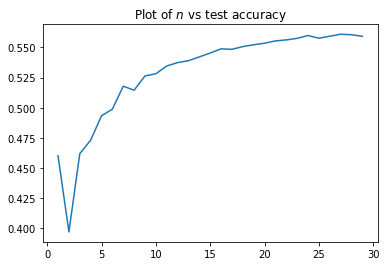

In [ ]:
plt.plot(num_neighbors, test_accuracies)
plt.title(r"Plot of $n$ vs test accuracy")
# plt.savefig("kmeans_normalzied.png")
plt.show()

Obviously this is not optimal, by excluding all non-ordinal variables we are potentially overlooking a lot of useful information about the patients. We will further process the data by first converting everything into a massive stack of onehot encodings, each element of the stack corresponds to a non-numeric label. Then, by using PCA we can try to reduce the dimensionality of this entire stack so that we can still run KNN efficiently.

### With all features

In [7]:
from sklearn.preprocessing import OneHotEncoder
#replace all labels that are already binary with simple binary labels
# for col, vals in possible_values.items():
#   if (len(vals) == 2):
#     i = 0
#     for val in vals:
#       full_dataset[col].replace(val, i, inplace=True)
#       i+=1
# possible_values = get_possible_values(full_dataset, verbose=False)

#standardize all numerical values of full_dataset
enc = OneHotEncoder()
enc.fit(full_dataset[["race", "gender", "admission_type_id", "discharge_disposition_id", 
              "admission_source_id", "diag_1", "diag_2", "diag_3",
              "max_glu_serum", "A1Cresult", "metformin", "repaglinide",
              "nateglinide", 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed']])

train, test = np.split(full_dataset.sample(frac=1, random_state=42), [int(.8*len(full_dataset))])
X_train = train[["age", "time_in_hospital", "num_lab_procedures", "num_procedures", 
                  "num_medications", "number_outpatient", "number_emergency", 
                  "number_inpatient", "number_diagnoses"]]
X_test = test[["age", "time_in_hospital", "num_lab_procedures", "num_procedures", 
                  "num_medications", "number_outpatient", "number_emergency", 
                  "number_inpatient", "number_diagnoses"]]
y_train = train["readmitted"]
y_test = test["readmitted"]
X_train = (X_train - X_train.mean()) / X_train.std()
X_test = (X_test - X_test.mean()) / X_test.std()

one_hot_train = enc.transform(train[["race", "gender", "admission_type_id", "discharge_disposition_id", 
              "admission_source_id", "diag_1", "diag_2", "diag_3",
              "max_glu_serum", "A1Cresult", "metformin", "repaglinide",
              "nateglinide", 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed']])
print(one_hot_train.shape)
one_hot_test = enc.transform(test[["race", "gender", "admission_type_id", "discharge_disposition_id", 
              "admission_source_id", "diag_1", "diag_2", "diag_3",
              "max_glu_serum", "A1Cresult", "metformin", "repaglinide",
              "nateglinide", 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed']])

X_train = pd.concat([X_train.reset_index(drop=True), (2 * pd.DataFrame(one_hot_train.toarray()) - 1).reset_index(drop=True)], axis = 1)
X_test = pd.concat([X_test.reset_index(drop=True), (2 * pd.DataFrame(one_hot_test.toarray()) - 1).reset_index(drop=True)], axis = 1)


(78441, 2377)


Now, we run PCA on data.

[[ 1.          0.09656601  0.01764677 ...  0.04199294  0.01779385
  -0.01779385]
 [ 0.09656601  1.          0.31685294 ... -0.10706029 -0.05292587
   0.05292587]
 [ 0.01764677  0.31685294  1.         ... -0.0622863  -0.02654492
   0.02654492]
 ...
 [ 0.04199294 -0.10706029 -0.0622863  ...  1.00001275  0.38458695
  -0.38458695]
 [ 0.01779385 -0.05292587 -0.02654492 ...  0.38458695  1.00001275
  -1.00001275]
 [-0.01779385  0.05292587  0.02654492 ... -0.38458695 -1.00001275
   1.00001275]]


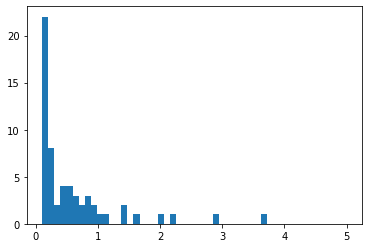

In [8]:
#calculate the correlation matrix
train_array = X_train.to_numpy()
corr = (train_array.T @ train_array) / (train_array.shape[0] - 1)
del(train_array)
print(corr)
from scipy import linalg
w,v = linalg.eigh(corr)
plt.clf()
plt.hist(w, bins=50, range=(0.1, 5))
plt.show()  

(2386, 5)
[2.34222184e+03 3.67596741e+00 2.86142095e+00 2.24384328e+00
 2.01083818e+00]


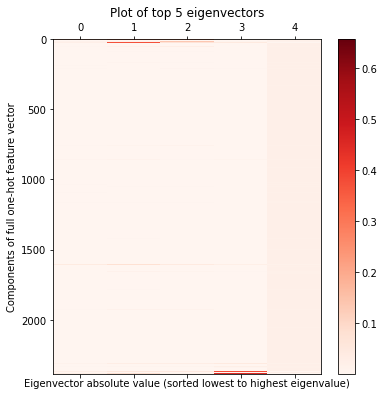

In [75]:
#Try to figure out what the top 5 principle axes are.

top5v, top5w = (v[:,-5:])[:,::-1], w[-5:][::-1]
print(top5v.shape)
print(top5w)
plt.matshow(np.abs(v[:,-5:]),aspect='auto', cmap=plt.cm.Reds)
fig = plt.gcf()
fig.set_size_inches(6,6)
plt.xlabel("Eigenvector absolute value (sorted lowest to highest eigenvalue)")
plt.ylabel("Components of full one-hot feature vector")
plt.title("Plot of top 5 eigenvectors")
plt.colorbar()
plt.savefig('PCA_eigmatshow5.png')
plt.show()

['race_AfricanAmerican' 'race_Asian' 'race_Caucasian' ... 'change_No'
 'diabetesMed_No' 'diabetesMed_Yes']


In [112]:
feature_names = enc.get_feature_names_out()
print(top5v[:,3])
for j in range(5):
  print("vector number " + str(j) + ":")
  print("-----------------------------")
  for i, val in enumerate(top5v[:,j]):
    if (np.abs(val) > 0.1):
      if(type(X_train.columns[i]) is int):
        print(feature_names[X_train.columns[i]] + " with val " + str(val))
      else:
        print(str(X_train.columns[i]) + " with val " + str(val))
  print("\n")
print(np.std(top5v[:,0]))


[-0.26969442 -0.41129866 -0.20927279 ... -0.08685838 -0.11014279
  0.11014279]
vector number 0:
-----------------------------


vector number 1:
-----------------------------
time_in_hospital with val -0.13943541357654413
num_medications with val -0.23077410781429242
metformin_No with val 0.14181043810485042
metformin_Steady with val -0.12672687451885553
insulin_Down with val -0.12396684692417416
insulin_No with val 0.3799918536214074
insulin_Steady with val -0.13786387809307118
insulin_Up with val -0.11759804268172654
change_Ch with val -0.45021923375116374
change_No with val 0.4502192337511638
diabetesMed_No with val 0.34470569287897596
diabetesMed_Yes with val -0.344705692878976


vector number 2:
-----------------------------
num_lab_procedures with val -0.22877210866101924
num_procedures with val 0.19160227383783268
number_diagnoses with val -0.1376792096003468
admission_type_id_1 with val -0.5022447672224075
admission_type_id_2 with val 0.13621086688643855
admission_type_id_3 wit

Further analysis of first eigenvector shows that it is pretty much just +/- some constant, in particular 0.0206 for every component. This is to be expected considering after standardizing  each one hot datapoint we end up with vectors that are for the most part just 1s and -1s. This eigenvector accounts is representative of that fact because it is itself mostly a bunch of 1s and -1s scaled by some constant which normalizes it. The other eigenvectors are more interesting.

In [107]:
# for i, val in enumerate(top5v[:,0]):
#     if (np.abs(val) > 0.02):
#       print(str(X_train.columns[i]) + " with val " + str(val))
print(np.std(top5v[:,0]))
print(np.linalg.norm(top5v[:,0]))

0.0043105491889494805
0.9999999999999999


In [ ]:
# print(w[-1])
# print(v[-1])
# print(v.shape)
# inds = np.argsort(v[-1])
# print(inds)
# insight_vector = np.zeros(v.shape[0])
# for i in range(7):
#   print(v[-1][inds[i]])
#   print(inds[i])
#   insight_vector[inds[i]] = 1
# for i in range(1, 9):
#   print(v[-1][inds[-i]])
#   print(inds[-i])
#   # insight_vector[inds[-i]] = 
# enc.inverse_transform(insight_vector.reshape(1,-1))

In [ ]:
transform_mat = v[w > 0.1]
print(transform_mat.shape)
processed_X_train = X_train @ transform_mat.T
print(processed_X_train.shape)
processed_X_test = X_test @ transform_mat.T
print(processed_X_test.shape)

(60, 2386)
(78441, 60)
(19611, 60)


1
0.4737647238794554
2
0.41135077252562335
3
0.47845596858905715
4
0.49247871092754064
5
0.5029320279435011
6
0.5080821987659987
7
0.5238896537657437
8
0.5241956045076742
9
0.5311304879914334
10
0.5325072663301208
11
0.5360766916526439
12
0.5380143796848708
13
0.5425526490235072
14
0.5437254602009076
15
0.5453062057008822
16
0.5469889347815001
17
0.5479577787976135
18
0.5490286063943705
19
0.5501504257814492
20
0.5500484422008056
21
0.5514252205394932
22
0.5522410891846413
23
0.5551986130233032
24
0.554178777216868
25
0.5549946458620162
26
0.5553515883942686
27
0.5570343174748865
28
0.5547906787007292
29
0.5562184488297384


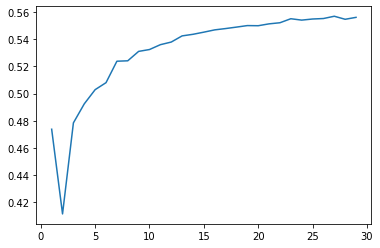

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

num_neighbors = range(1,30)
test_accuracies = []
for num in num_neighbors:
  print(num)
  classifier = KNeighborsClassifier(num)
  classifier.fit(processed_X_train, y_train)
  predicted = classifier.predict(processed_X_test)
  count = np.count_nonzero(y_test==predicted)
  test_accuracies.append(count / len(y_test))
  print(count/len(y_test))
np.save("KNN_normalized_full_pca", test_accuracies)
plt.clf()
plt.plot(num_neighbors, test_accuracies, label=r"Plot of test accuracy vs $n$ for full PCA reduced features")
plt.savefig("KNN_normalized_full_pca.png")

In [ ]:
def genKNNGraph():
  unnormalized = np.load("KNN_unnormalized_only_ordinal.npy")
  full_pca = np.load("KNN_normalized_full_pca.npy")
  normalized = np.load("KNN_normalized_only_ordinal.npy")
  xvals = range(1, 30)
  plt.clf()
  plt.plot(xvals, unnormalized*100, label="Unnormalized, only numbers")
  plt.plot(xvals, full_pca*100, label="Normalized, all features")
  plt.plot(xvals, normalized*100, label="Normalized, only numbers")
  plt.legend()
  plt.ylabel("Validation set accuracy (%)")
  plt.xlabel(r"$k$")
  plt.title(r"Plot of validation accuracy vs $k$ for different data preprocessings")
  plt.savefig("figure1.png")
genKNNGraph()

NameError: ignored

## GLM

Next I will try exploring some generalized linear models. We can pretty much just use the preprocessed data from the KNN again here. The data has already been standardized. The only issue is that regular GLMs assume 

In [ ]:
processed_data = {'train_X': processed_X_train, 'train_Y': y_train, 
                  'test_X': processed_X_test, 'test_Y': y_test}
np.save("processed_data", processed_data)

In [66]:
processed_data = np.load("processed_data.npy", allow_pickle=True).item()
processed_X_train, y_train, processed_X_test, y_test = processed_data['train_X'], processed_data['train_Y'], processed_data['test_X'], processed_data['test_Y']
print(processed_X_train.shape)
print(processed_X_test.shape)

(78441, 60)
(19611, 60)


In [ ]:
#logistic regression
y_train_simple = y_train.replace("NO", 0, inplace=False)
y_train_simple.replace(">30", 1, inplace=True)
y_train_simple.replace("<30", 1, inplace=True)
y_test_simple = y_test.replace("NO", 0, inplace=False)
y_test_simple.replace(">30", 1, inplace=True)
y_test_simple.replace("<30", 1, inplace=True)

classifier = KNeighborsClassifier(30)
classifier.fit(processed_X_train, y_train_simple)
predicted = classifier.predict(processed_X_test)
count = np.count_nonzero(y_test_simple==predicted)
print(count / len(predicted))

from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression(max_iter=1000, solver='sag')

classifier.fit(processed_X_train, y_train_simple)

print(classifier.score(processed_X_test, y_test_simple))


0.6051705675386263
0.6160828106674825


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


In [ ]:
from sklearn.linear_model import LogisticRegression

#without simplifications:
classifier = LogisticRegression(multi_class='multinomial', max_iter=1000, solver='sag')

classifier.fit(processed_X_train, y_train)

print(classifier.score(processed_X_test, y_test))


0.5653969710876549


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


Using the multinomial distribution as the exponential family distribution instead allows us to handle the unsimplified labels. Similar to the previous part, we find that this multinomial logistic regression allows for slightly better test accuracy of 56.5% compared to the kNN algorithm which achieved accuracy of 55.6% at its best. 

In order to compare the decision boundaries obtained by these two different algorithms, it is simplest to plug in all the datapoints classified in each category by logistic regression into kNN and see how many datapoints agree.

In [ ]:
predicted = classifier.predict(processed_X_test)
classifier_knn = KNeighborsClassifier(30)
classifier_knn.fit(processed_X_train, y_train)
predicted_knn = classifier_knn.predict(processed_X_test)


0.797766559583907
15645
19611
3966
[[1.3317e+04 2.5210e+03 1.3000e+01]
 [1.3430e+03 2.3090e+03 5.2000e+01]
 [3.0000e+00 3.4000e+01 1.9000e+01]]


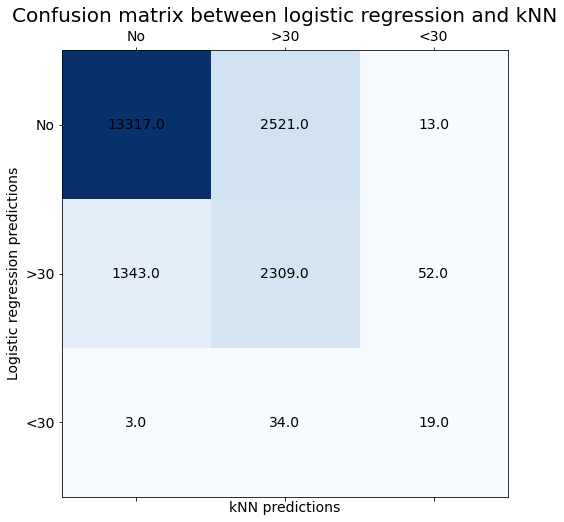

In [ ]:
count = 0
different = []
for i, pred in enumerate(predicted):
  if (pred == predicted_knn[i]):
    count +=1
  else:
    different.append(i)
agreement_accuracy = count / len(predicted)
print(agreement_accuracy)
print(count)
print(len(predicted))
dif_matrix = np.zeros((3,3))
dif_matrix2 = np.zeros((3,3))
correct_count = 0
print(len(different))
for i, pred in enumerate(predicted):
  r = 0
  c = 0
  if (pred == 'NO'):
    r = 0
  elif (pred == '>30'):
    r = 1
  elif (pred == '<30'):
    r = 2
  if (predicted_knn[i] == 'NO'):
    c = 0
  elif (predicted_knn[i] == '>30'):
    c = 1
  elif (predicted_knn[i] == '<30'):
    c = 2
  dif_matrix[r,c] += 1
  # if(predicted[i] == y_test.iloc[i]):
  #   if (predicted[i] == 'NO'):
  #     r = 0
  #   elif (predicted[i] == '>30'):
  #     r = 1
  #   elif (predicted[i] == '<30'):
  #     r = 2
  #   if (predicted_knn[i] == 'NO'):
  #     c = 0
  #   elif (predicted_knn[i] == '>30'):
  #     c = 1
  #   elif (predicted_knn[i] == '<30'):
  #     c = 2
  #   dif_matrix[r,c] += 1
  # elif (predicted_knn[i] == y_test.iloc[i]):
  #   if (predicted[i] == 'NO'):
  #     r = 0
  #   elif (predicted[i] == '>30'):
  #     r = 1
  #   elif (predicted[i] == '<30'):
  #     r = 2
  #   if (predicted_knn[i] == 'NO'):
  #     c = 0
  #   elif (predicted_knn[i] == '>30'):
  #     c = 1
  #   elif (predicted_knn[i] == '<30'):
  #     c = 2
  #   dif_matrix2[r,c] += 1
  
print(dif_matrix)
plt.matshow(dif_matrix, cmap=plt.cm.Blues)
for i in range(3):
    for j in range(3):
        c = dif_matrix[j,i]
        plt.text(i, j, str(c), va='center', ha='center', fontsize=14)
plt.xticks([0, 1, 2], ['No', '>30', '<30'], fontsize=14)
plt.yticks([0, 1, 2], ['No', '>30', '<30'], fontsize=14)
plt.xlabel("kNN predictions", fontsize=14)
plt.ylabel('Logistic regression predictions', fontsize=14)
plt.title('Confusion matrix between logistic regression and kNN', fontsize=20)
fig = plt.gcf()
fig.set_size_inches(8, 8)
plt.savefig('logregvsknnconfusion.png')
plt.show()
# plt.matshow(dif_matrix2, cmap=plt.cm.Blues)
# for i in range(3):
#     for j in range(3):
#         c = dif_matrix2[j,i]
#         plt.text(i, j, str(c), va='center', ha='center')
# plt.xticks([0, 1, 2], ['No', '>30', '<30'])
# plt.yticks([0, 1, 2], ['No', '>30', '<30'])
# plt.xlabel("kNN predictions")
# plt.ylabel('Logistic regression predictions')
# plt.title('Difference matrix for points predicted correctly by kNN but not logistic regression')
# plt.show()
# print(len(y_test))
# print(correct_count)

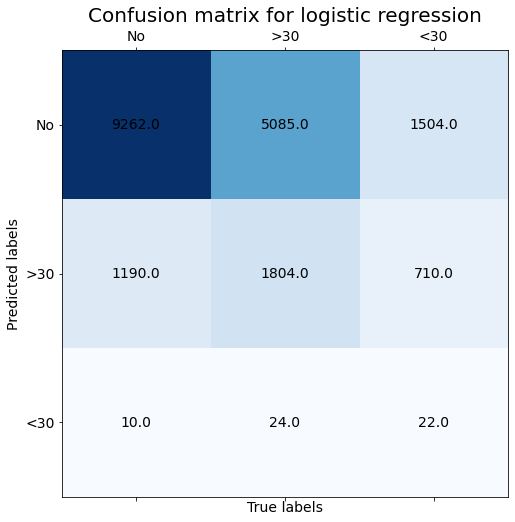

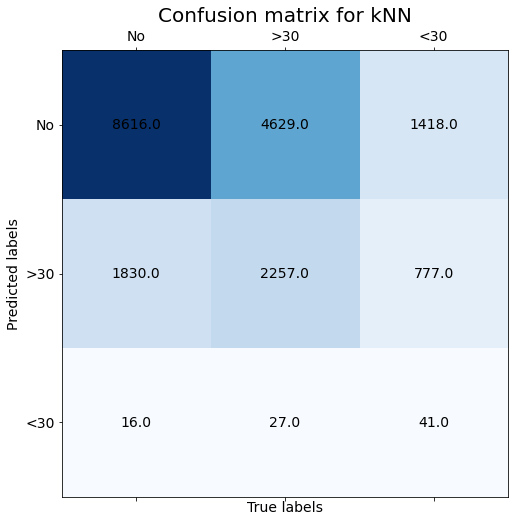

In [ ]:
confusion_matrix_1 = np.zeros((3,3))
confusion_matrix_2 = np.zeros((3,3))
for i, pred in enumerate(predicted):
  r = 0
  c = 0
  if (predicted[i] == 'NO'):
      r = 0
  elif (predicted[i] == '>30'):
    r = 1
  elif (predicted[i] == '<30'):
    r = 2
  if (y_test.iloc[i] == 'NO'):
    c = 0
  elif (y_test.iloc[i] == '>30'):
    c = 1
  elif (y_test.iloc[i] == '<30'):
    c = 2
  confusion_matrix_1[r,c] += 1
  r = 0
  c = 0
  if (predicted_knn[i] == 'NO'):
      r = 0
  elif (predicted_knn[i] == '>30'):
    r = 1
  elif (predicted_knn[i] == '<30'):
    r = 2
  if (y_test.iloc[i] == 'NO'):
    c = 0
  elif (y_test.iloc[i] == '>30'):
    c = 1
  elif (y_test.iloc[i] == '<30'):
    c = 2
  confusion_matrix_2[r,c] += 1
plt.matshow(confusion_matrix_1, cmap=plt.cm.Blues)
for i in range(3):
    for j in range(3):
        c = confusion_matrix_1[j,i]
        plt.text(i, j, str(c), va='center', ha='center', fontsize=14)
plt.xticks([0, 1, 2], ['No', '>30', '<30'], fontsize = 14)
plt.yticks([0, 1, 2], ['No', '>30', '<30'], fontsize = 14)
plt.xlabel("True labels", fontsize = 14)
plt.ylabel('Predicted labels', fontsize = 14)
plt.title('Confusion matrix for logistic regression', fontsize=20)
fig = plt.gcf()
fig.set_size_inches(8, 8)
plt.savefig('Confusion_matrix_logreg.png')
plt.show()
plt.matshow(confusion_matrix_2, cmap=plt.cm.Blues)
for i in range(3):
    for j in range(3):
        c = confusion_matrix_2[j,i]
        plt.text(i, j, str(c), va='center', ha='center', fontsize=14)
plt.xticks([0, 1, 2], ['No', '>30', '<30'], fontsize = 14)
plt.yticks([0, 1, 2], ['No', '>30', '<30'], fontsize = 14)
plt.xlabel("True labels", fontsize = 14)
plt.ylabel('Predicted labels', fontsize = 14)
plt.title('Confusion matrix for kNN', fontsize=20)
fig = plt.gcf()
fig.set_size_inches(8, 8)
plt.savefig('Confusion_matrix_kNN.png')
plt.show()

In [ ]:
print(np.count_nonzero(predicted_knn == y_test))
print(np.count_nonzero(predicted == y_test))
print(len(y_test))

10914
11089
19611


Almost all of the disagreement comes from predicting a patient will be readmitted in >30 days vs not being readmitted. We see that the decision boundary for logistic regression much more heavily favors being admitted 

## Decision tree

Before moving on to random forests, for a first attempt will try to use decision trees. But these tend to overfit so we expect to see extremely high train accuracy with very low test accuracy.

5
10
15
20
25
30
35
40
45


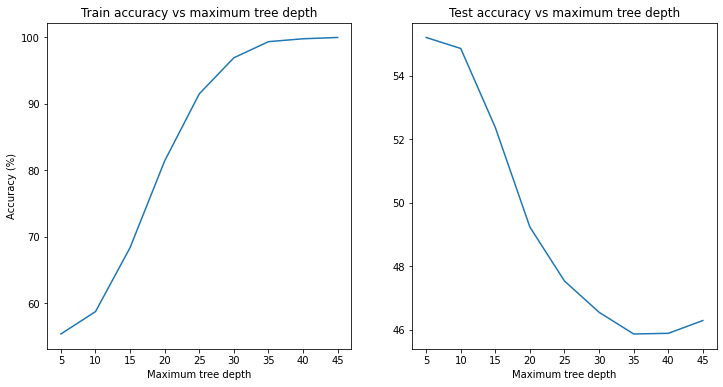

In [ ]:
from sklearn.tree import DecisionTreeClassifier

max_depth =  np.arange(5, 50, 5)
train_acc = []
test_acc = []
for depth in max_depth:
  print(depth)
  treeclf = DecisionTreeClassifier(criterion='entropy', max_depth=depth)
  treeclf.fit(processed_X_train, y_train)
  test_acc.append(treeclf.score(processed_X_test, y_test))
  train_acc.append(treeclf.score(processed_X_train, y_train))
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.set_title("Train accuracy vs maximum tree depth")
ax2.set_title("Test accuracy vs maximum tree depth")
ax1.plot(max_depth, np.asarray(train_acc) * 100, label="Train accuracy")
ax2.plot(max_depth, np.asarray(test_acc) * 100, label="Test accuracy")
fig.set_size_inches(12, 6)
ax1.set_ylabel("Accuracy (%)")
ax1.set_xlabel("Maximum tree depth")
ax2.set_xlabel("Maximum tree depth")
plt.savefig('train_and_test_acc_dectree.png')


1
2
3
4
5
6
7
8
9
10


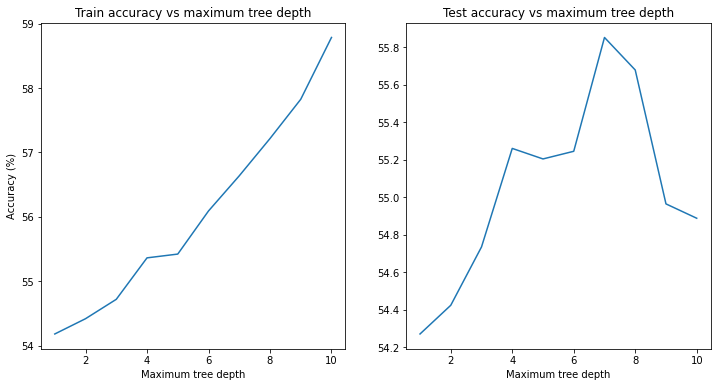

In [ ]:
max_depth =  np.arange(1, 11, 1)
train_acc = []
test_acc = []
for depth in max_depth:
  print(depth)
  treeclf = DecisionTreeClassifier(criterion='entropy', max_depth=depth)
  treeclf.fit(processed_X_train, y_train)
  test_acc.append(treeclf.score(processed_X_test, y_test))
  train_acc.append(treeclf.score(processed_X_train, y_train))
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.set_title("Train accuracy vs maximum tree depth")
ax2.set_title("Test accuracy vs maximum tree depth")
ax1.plot(max_depth, np.asarray(train_acc) * 100, label="Train accuracy")
ax2.plot(max_depth, np.asarray(test_acc) * 100, label="Test accuracy")
fig.set_size_inches(12, 6)
ax1.set_ylabel("Accuracy (%)")
ax1.set_xlabel("Maximum tree depth")
ax2.set_xlabel("Maximum tree depth")
plt.savefig('train_and_test_acc_dectree_zoom.png')

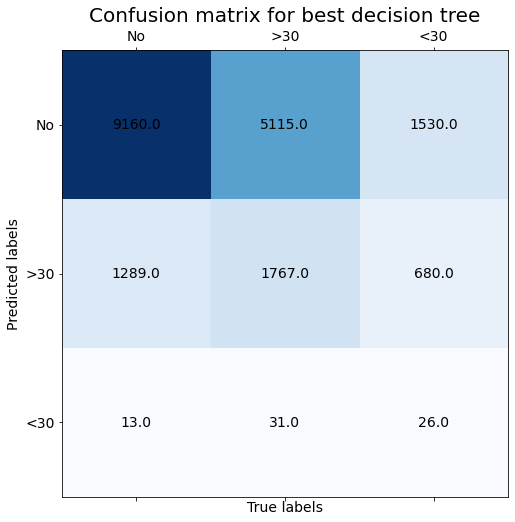

In [ ]:
confusion_matrix = np.zeros((3,3))
besttreeclf =DecisionTreeClassifier(criterion='entropy', max_depth = 7)
besttreeclf.fit(processed_X_train, y_train)
for i, pred in enumerate(besttreeclf.predict(processed_X_test)):
  r = 0
  c = 0
  if (pred == 'NO'):
    r = 0
  elif (pred == '>30'):
    r = 1
  elif (pred == '<30'):
    r = 2
  if (y_test.iloc[i] == 'NO'):
    c = 0
  elif (y_test.iloc[i] == '>30'):
    c = 1
  elif (y_test.iloc[i] == '<30'):
    c = 2
  confusion_matrix[r,c] += 1
plt.matshow(confusion_matrix, cmap=plt.cm.Blues)
for i in range(3):
    for j in range(3):
        c = confusion_matrix[j,i]
        plt.text(i, j, str(c), va='center', ha='center', fontsize=14)
plt.xticks([0, 1, 2], ['No', '>30', '<30'], fontsize = 14)
plt.yticks([0, 1, 2], ['No', '>30', '<30'], fontsize = 14)
plt.xlabel("True labels", fontsize = 14)
plt.ylabel('Predicted labels', fontsize = 14)
plt.title('Confusion matrix for best decision tree', fontsize=20)
fig = plt.gcf()
fig.set_size_inches(8, 8)
plt.savefig('Confusion_matrix_DT.png')
plt.show()

## Random Forest

Same experiments done for the random forest classifier

1
6
11
16
21


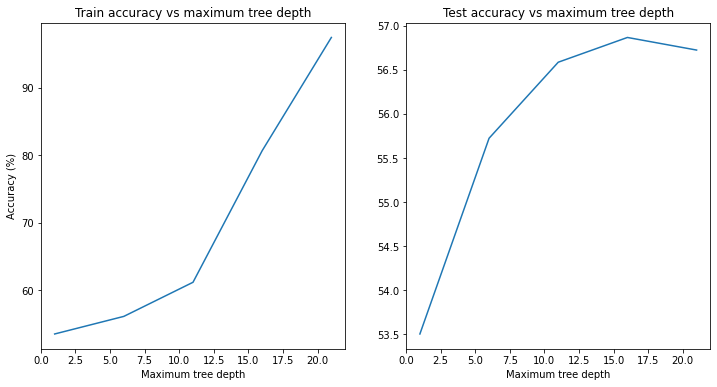

In [ ]:
from sklearn.ensemble import RandomForestClassifier
max_depth =  np.arange(1, 26, 5)
train_acc = []
test_acc = []
for depth in max_depth:
  print(depth)
  treeclf = RandomForestClassifier(criterion='entropy', max_depth = depth)
  treeclf.fit(processed_X_train, y_train)
  test_acc.append(treeclf.score(processed_X_test, y_test))
  train_acc.append(treeclf.score(processed_X_train, y_train))
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.set_title("Train accuracy vs maximum tree depth")
ax2.set_title("Test accuracy vs maximum tree depth")
ax1.plot(max_depth, np.asarray(train_acc) * 100, label="Train accuracy")
ax2.plot(max_depth, np.asarray(test_acc) * 100, label="Test accuracy")
fig.set_size_inches(12, 6)
ax1.set_ylabel("Accuracy (%)")
ax1.set_xlabel("Maximum tree depth")
ax2.set_xlabel("Maximum tree depth")
plt.savefig('train_and_test_acc_randforest_wider.png')


0.5701901993779002


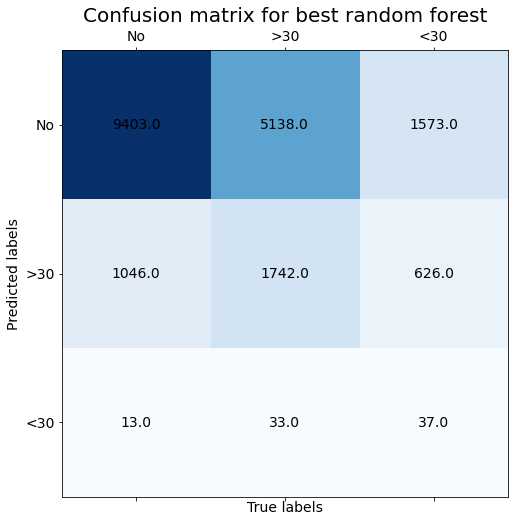

In [ ]:
confusion_matrix = np.zeros((3,3))
besttreeclf = RandomForestClassifier(criterion='entropy', max_depth = 16)
besttreeclf.fit(processed_X_train, y_train)
print(besttreeclf.score(processed_X_test, y_test))
for i, pred in enumerate(besttreeclf.predict(processed_X_test)):
  r = 0
  c = 0
  if (pred == 'NO'):
    r = 0
  elif (pred == '>30'):
    r = 1
  elif (pred == '<30'):
    r = 2
  if (y_test.iloc[i] == 'NO'):
    c = 0
  elif (y_test.iloc[i] == '>30'):
    c = 1
  elif (y_test.iloc[i] == '<30'):
    c = 2
  confusion_matrix[r,c] += 1
plt.matshow(confusion_matrix, cmap=plt.cm.Blues)
for i in range(3):
    for j in range(3):
        c = confusion_matrix[j,i]
        plt.text(i, j, str(c), va='center', ha='center', fontsize=14)
plt.xticks([0, 1, 2], ['No', '>30', '<30'], fontsize = 14)
plt.yticks([0, 1, 2], ['No', '>30', '<30'], fontsize = 14)
plt.xlabel("True labels", fontsize = 14)
plt.ylabel('Predicted labels', fontsize = 14)
plt.title('Confusion matrix for best random forest', fontsize=20)
fig = plt.gcf()
fig.set_size_inches(8, 8)
plt.savefig('Confusion_matrix_RF.png')
plt.show()

## Deep neural network

In [113]:
from sklearn.neural_network import MLPClassifier

nnclf = MLPClassifier(solver='adam', hidden_layer_sizes=(120, 60, 20), verbose=True, early_stopping=True)
nnclf.fit(processed_X_train, y_train)

Iteration 1, loss = 0.93120286
Validation score: 0.568515
Iteration 2, loss = 0.91145247
Validation score: 0.570682
Iteration 3, loss = 0.90503717
Validation score: 0.572339
Iteration 4, loss = 0.89928318
Validation score: 0.573741
Iteration 5, loss = 0.89634221
Validation score: 0.577565
Iteration 6, loss = 0.89437676
Validation score: 0.576546
Iteration 7, loss = 0.89314514
Validation score: 0.579095
Iteration 8, loss = 0.89223341
Validation score: 0.578203
Iteration 9, loss = 0.89109249
Validation score: 0.575398
Iteration 10, loss = 0.88973188
Validation score: 0.578330
Iteration 11, loss = 0.88956247
Validation score: 0.571192
Iteration 12, loss = 0.88844355
Validation score: 0.577183
Iteration 13, loss = 0.88785130
Validation score: 0.575398
Iteration 14, loss = 0.88657547
Validation score: 0.575908
Iteration 15, loss = 0.88583970
Validation score: 0.575016
Iteration 16, loss = 0.88570920
Validation score: 0.581644
Iteration 17, loss = 0.88542574
Validation score: 0.578585
Iterat

MLPClassifier(early_stopping=True, hidden_layer_sizes=(120, 60, 20),
              verbose=True)

0.5730457396359186


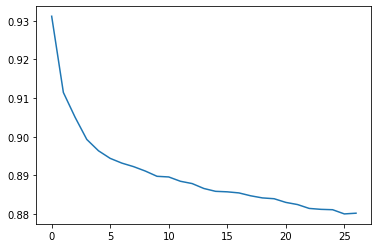

In [114]:
print(nnclf.score(processed_X_test, y_test))
plt.plot(nnclf.loss_curve_)


In [128]:
import pickle
pickle.dump(nnclf, open('best_model_earlystop.sav', 'wb'))

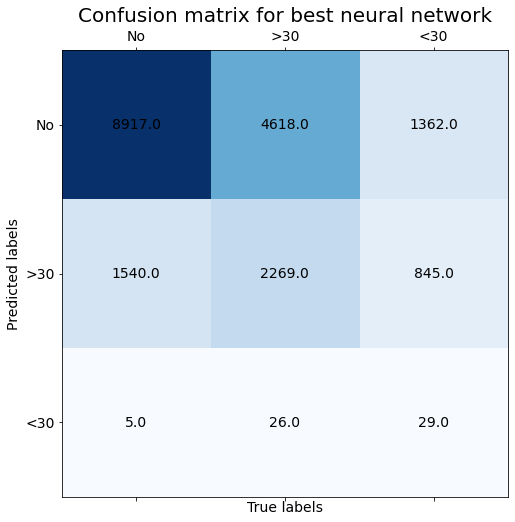

In [131]:
import pickle
pickle.load(open('best_model_earlystop.sav', 'rb'))
confusion_matrix = np.zeros((3,3))
for i, pred in enumerate(nnclf.predict(processed_X_test)):
  r = 0
  c = 0
  if (pred == 'NO'):
    r = 0
  elif (pred == '>30'):
    r = 1
  elif (pred == '<30'):
    r = 2
  if (y_test.iloc[i] == 'NO'):
    c = 0
  elif (y_test.iloc[i] == '>30'):
    c = 1
  elif (y_test.iloc[i] == '<30'):
    c = 2
  confusion_matrix[r,c] += 1
plt.matshow(confusion_matrix, cmap=plt.cm.Blues)
for i in range(3):
    for j in range(3):
        c = confusion_matrix[j,i]
        plt.text(i, j, str(c), va='center', ha='center', fontsize=14)
plt.xticks([0, 1, 2], ['No', '>30', '<30'], fontsize = 14)
plt.yticks([0, 1, 2], ['No', '>30', '<30'], fontsize = 14)
plt.xlabel("True labels", fontsize = 14)
plt.ylabel('Predicted labels', fontsize = 14)
plt.title('Confusion matrix for best neural network', fontsize=20)
fig = plt.gcf()
fig.set_size_inches(8, 8)
plt.savefig('Confusion_matrix_nn.png')
plt.show()

0.0001
0.001
0.01
0.1
1


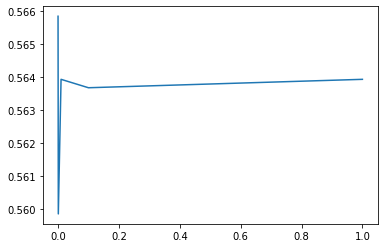

In [117]:
#testing different regularization rates
alphas = [0.0001, 0.001, 0.01, 0.1, 1]
from sklearn.neural_network import MLPClassifier
import pickle
val_accs = []
processed_X_trainsplit, processed_X_valid = np.split(processed_X_train.sample(frac=1, random_state=42), [int(.9*len(processed_X_train))])
y_trainsplit, y_valid = np.split(y_train.sample(frac=1, random_state=42), [int(.9*len(y_train))])
for reg in alphas:
  print(reg)
  nnclf = MLPClassifier(solver='adam', hidden_layer_sizes=(120, 60, 20), early_stopping=True)
  nnclf.fit(processed_X_trainsplit, y_trainsplit)
  val_accs.append(nnclf.score(processed_X_valid, y_valid))
  pickle.dump(nnclf, open('modelwithreg=' + str(reg) + '.sav', 'wb'))

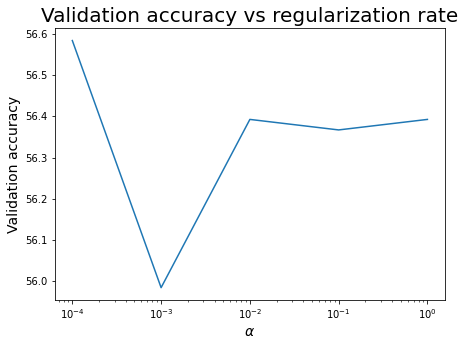

In [127]:
plt.title('Validation accuracy vs regularization rate', fontsize=20)
plt.plot(alphas, 100*np.asarray(val_accs))
plt.xscale('log')
plt.xlabel(r'$\alpha$', fontsize=14)
plt.ylabel('Validation accuracy', fontsize=14)
fig = plt.gcf()
fig.set_size_inches(7,5)
plt.savefig('Valaccuracyvsregrate.png')

## Balancing dataset

Due to the imbalance of the dataset all classifiers tend to give many many more NO guesses than anything else. Reweighting the test dataset shows that in fact the best algorithm would have actually been:

In [241]:
print(y_test.value_counts())

NO     10462
>30     6913
<30     2236
Name: readmitted, dtype: int64


In [293]:
from json import load
import pickle

from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

def score_all_models():
  X = processed_X_test.to_numpy()
  Y = y_test_simple.to_numpy()
  model_names = ['Logistic regression', 'kNN', 'Decision tree', 'Random forest', 'Deep neural network']
  models = [
  pickle.load(open('./models/logreg.sav', 'rb')),
  pickle.load(open('./models/knn.sav', 'rb')),
  pickle.load(open('./models/tree.sav', 'rb')),
  pickle.load(open('./models/forest.sav', 'rb')),
  pickle.load(open('./models/nn.sav', 'rb'))
  ]
  for i in range(len(models)):
    predictions = models[i].predict(processed_X_test)
    print(model_names[i] + ' achieved test set accuracy of: ' + str(models[i].score(processed_X_test, y_test)))

def weighted_score_all_models():
  X = processed_X_test.to_numpy()
  Y = y_test.to_numpy()
  model_names = ['Logistic regression', 'kNN', 'Decision tree', 'Random forest', 'Deep neural network']
  models = [
  pickle.load(open('./models/logreg.sav', 'rb')),
  pickle.load(open('./models/knn.sav', 'rb')),
  pickle.load(open('./models/tree.sav', 'rb')),
  pickle.load(open('./models/forest.sav', 'rb')),
  pickle.load(open('./models/nn.sav', 'rb'))
  ]
  for i in range(len(models)):
    predictions = models[i].predict(processed_X_test)
    print(set(predictions))
    totals = np.zeros(3)
    counts = np.zeros(3)
    for ind, y in enumerate(Y):
      if (y == 'NO'):
        totals[0]+=1
        if(predictions[ind] == y):
          counts[0]+=1
      elif (y == '>30'):
        totals[1]+=1
        if(predictions[ind] == y):
          counts[1]+=1
      else:
        totals[2]+=1
        if(predictions[ind] == y):
          counts[2]+=1
    print(counts)
    print(totals)
    weighted_acc = np.sum((counts / totals)) /3
    print(model_names[i] + ' achieved test set accuracy of: ' + str(weighted_acc))

In [259]:
score_all_models()


Logistic regression achieved test set accuracy of: 0.5653969710876549
kNN achieved test set accuracy of: 0.556524399571669
Decision tree achieved test set accuracy of: 0.5585130793942176
Random forest achieved test set accuracy of: 0.5694253225230738
Deep neural network achieved test set accuracy of: 0.5767681403294069


In [294]:
weighted_score_all_models()

{'>30', '<30', 'NO'}
[9262. 1804.   22.]
[10462.  6913.  2236.]
Logistic regression achieved test set accuracy of: 0.38536526409138966
{'>30', '<30', 'NO'}
[8616. 2257.   41.]
[10462.  6913.  2236.]
kNN achieved test set accuracy of: 0.38945818235753765
{'>30', '<30', 'NO'}
[9160. 1767.   26.]
[10462.  6913.  2236.]
Decision tree achieved test set accuracy of: 0.38092763208272945
{'>30', '<30', 'NO'}
[9386. 1742.   39.]
[10462.  6913.  2236.]
Random forest achieved test set accuracy of: 0.38886082097946256
{'>30', '<30', 'NO'}
[9114. 2169.   28.]
[10462.  6913.  2236.]
Deep neural network achieved test set accuracy of: 0.39914393163818235


## Trying all on only binary labels

Another way to fix this balancing issue is to simply ignore the $\lt 30$ vs $\gt 30$ distinction and reuse our old simplified labels which turn the problem into a binary classification problem once again. This also allows us to calculate the ROI and the AUC, and using the reference paper's suggestion we can weight all the outputs of all the models and use that as the classifier instead. We will call this the aggregated model.

In [237]:
from json import load
import pickle

from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve


y_train_simple = y_train.replace("NO", 0, inplace=False)
y_train_simple.replace(">30", 1, inplace=True)
y_train_simple.replace("<30", 1, inplace=True)
y_test_simple = y_test.replace("NO", 0, inplace=False)
y_test_simple.replace(">30", 1, inplace=True)
y_test_simple.replace("<30", 1, inplace=True)
print(y_test_simple.value_counts())

def train_binary_models():
  weights = []
  yarr = y_test_simple.to_numpy()

  model = pickle.load(open('./binarymodels/logreg.sav', 'rb'))
  # model = LogisticRegression(max_iter=1000, solver='sag')
  # model.fit(processed_X_train, y_train_simple)
  # pickle.dump(model, open('./binarymodels/logreg.sav', 'wb'))
  prob = model.predict_proba(processed_X_test)[:,1]
  auc = roc_auc_score(yarr, prob)
  fpr, tpr, _ = roc_curve(yarr, prob)
  plt.plot(fpr, tpr, label='Logistic regressoin')
  weights.append(auc)

  model = pickle.load(open('./binarymodels/knn.sav', 'rb'))
  # model = KNeighborsClassifier(30)
  # model.fit(processed_X_train, y_train_simple)
  # pickle.dump(model, open('./binarymodels/knn.sav', 'wb')) 
  prob = model.predict_proba(processed_X_test)[:,1]
  auc = roc_auc_score(yarr, prob)
  fpr, tpr, _ = roc_curve(yarr, prob)
  plt.plot(fpr, tpr, label='kNN')
  weights.append(auc)

  model = pickle.load(open('./binarymodels/tree.sav', 'rb'))
  # model = DecisionTreeClassifier(criterion='entropy', max_depth = 7)
  # model.fit(processed_X_train, y_train_simple)
  # pickle.dump(model, open('./binarymodels/tree.sav', 'wb'))
  prob = model.predict_proba(processed_X_test)[:,1]
  auc = roc_auc_score(yarr, prob)
  fpr, tpr, _ = roc_curve(yarr, prob)
  plt.plot(fpr, tpr, label='Decision tree')
  weights.append(auc)

  model = pickle.load(open('./binarymodels/forest.sav', 'rb'))
  # model = RandomForestClassifier(criterion='entropy', max_depth = 16)
  # model.fit(processed_X_train, y_train_simple)
  # pickle.dump(model, open('./binarymodels/forest.sav', 'wb'))
  prob = model.predict_proba(processed_X_test)[:,1]
  auc = roc_auc_score(yarr, prob)
  fpr, tpr, _ = roc_curve(yarr, prob)
  plt.plot(fpr, tpr, label='Random forest')
  weights.append(auc)

  model = pickle.load(open('./binarymodels/nn.sav', 'rb'))
  # model = MLPClassifier(solver='adam', hidden_layer_sizes=(120, 60, 20), early_stopping=True)
  # model.fit(processed_X_train, y_train_simple)
  # pickle.dump(model, open('./binarymodels/nn.sav', 'wb'))
  prob = model.predict_proba(processed_X_test)[:,1]
  auc = roc_auc_score(yarr, prob)
  fpr, tpr, _ = roc_curve(yarr, prob)
  plt.plot(fpr, tpr, label="Neural network")
  weights.append(auc)

  np.save('./binarymodels/weights', weights)
  fig = plt.gcf()
  fig.set_size_inches(8, 6)
  plt.title('Comparison of ROC curves for all models', fontsize=20)
  plt.legend()
  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  plt.show()
  plt.savefig('ROC curves for all models')

def load_binary_models():
  models = [
  pickle.load(open('./binarymodels/logreg.sav', 'rb')),
  pickle.load(open('./binarymodels/knn.sav', 'rb')),
  pickle.load(open('./binarymodels/tree.sav', 'rb')),
  pickle.load(open('./binarymodels/forest.sav', 'rb')),
  pickle.load(open('./binarymodels/nn.sav', 'rb'))
  ]
  weights = np.load('./binarymodels/weights.npy')
  return models, weights

def score_aggregate_model():
  models, weights = load_binary_models()
  total = len(y_test_simple)
  yarr = y_test_simple.to_numpy()
  count = 0
  predictions = np.zeros(yarr.shape)
  for m, model in enumerate(models):
    predictions += weights[m] * model.predict(processed_X_test)
  predictions = np.round(predictions / len(models), decimals = 0)
  # for j in range(len(processed_X_test)):
  #   if(j%50 == 0): print(j)
  #   x = processed_X_test.iloc[j,:]
  #   # print(j)
  #   y = y_test_simple.iloc[j]
  #   prediction = 0
  #     weight = weights[m]
  #     prediction += weight * model.predict(x.to_numpy().reshape(1,-1))[0]
  #   prediction = np.round(prediction / len(models), decimals = 0)
  #   # print(prediction)
  #   if (prediction == y):
  #     count += 1
  print("Aggregate model achieved test set accuracy of: " + str(np.count_nonzero(predictions == yarr) / total))

def score_binary_models():
  model_names = ['Logistic regression', 'kNN', 'Decision tree', 'Random forest', 'Deep neural network']
  models, _ = load_binary_models()
  for i in range(len(models)):
    print(model_names[i] + ' achieved test set accuracy of: ' + str(models[i].score(processed_X_test, y_test_simple)))

0    10462
1     9149
Name: readmitted, dtype: int64


In [213]:
#train and score aggregate model
# train_binary_models()
# score_aggregate_model()
#score the binary models
score_binary_models()

Logistic regression achieved test set accuracy of: 0.6160828106674825
kNN achieved test set accuracy of: 0.6051705675386263
Decision tree achieved test set accuracy of: 0.59425832440977
Random forest achieved test set accuracy of: 0.6197032277803274
Deep neural network achieved test set accuracy of: 0.6270460455866605


In [214]:
score_aggregate_model()

Aggregate model achieved test set accuracy of: 0.6180714904900311


## References

Potential metric for KNN on categorical labels:
https://www.sciencedirect.com/science/article/pii/S0167947398000322

Dataset info:
https://www.hindawi.com/journals/bmri/2014/781670/tab1/

Publication for diabetes prediction:
https://journals.sagepub.com/doi/full/10.1177/0962280218810911?casa_token=e6MhgGr6j0QAAAAA%3Af64RUqqWFId_JVjfRTHvTJTsl7eOzE9-THKI5Eh8ZmXJeMjKPcsOj-ZNTlYgN0HIlKh4SDPe8qxm#_i13

How random forest works:
https://journals.sagepub.com/doi/full/10.1177/1536867X20909688

More diabetes papers:
https://ieeexplore.ieee.org/abstract/document/9076634

https://www.sciencedirect.com/science/article/pii/S1877050920300557


